<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 : West Nile Virus Prediction
### Notebook 3 of 4: Modeling

## Contents:
- [Import libraries](#Import-libraries)
- [Define functions](#Define-functions)
- [Import data from Pickle](#Import-data-from-Pickle)
- [Data Preparation](#Data-Preparation)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)
- [Model Submission](#Model-Submission)

# Import libraries
*Back to [Contents](#Contents:)*

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

C:\Users\olive\anaconda3\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
#!pip install imblearn

In [3]:
#!pip install lightgbm

# Define functions
*Back to [Contents](#Contents:)*

In [4]:
# The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, F1 score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and P-R curve
# 5. plot feature importance list

def run_model(gs, model_name, X_train, y_train, X_test, y_test):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    # print(gs.best_params_)
    if isinstance(gs, GridSearchCV):
        print("best_params: ")
        for (item, value) in gs.best_params_.items():
            print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_auc_score = gs.score(X_train, y_train)
    test_auc_score = gs.score(X_test, y_test)
    auc_perc_diff = np.abs(test_auc_score/train_auc_score*100-100)
    
    print(f'\nprecision_recall_auc_score on training set: {train_auc_score:.3f}')
    print(f'precision_recall_auc_score on testing set: {test_auc_score:.3f}')
    print(f'perc_diff: {auc_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_test_preds = gs.predict(X_test)
    
    # calculate the F1_score
    train_f1_score =  f1_score(y_train, y_train_preds)
    test_f1_score = f1_score(y_test, y_test_preds)
    f1_perc_diff = np.abs(test_f1_score/train_f1_score*100-100)
    print(f'f1_score on training set: {train_f1_score:.3f}')
    print(f'f1_score on testing set: {test_f1_score:.3f}')
    print(f'perc_diff: {f1_perc_diff:.1f} %\n')
    
    # Save confusion matrix values
    print("Confusion Matrix: ")
    cm = confusion_matrix(y_test, y_test_preds)
    cm_df = pd.DataFrame(cm, columns=['pred No virus', 'pred WnvPresent'], 
                         index=['actual No virus', 'actual WnvPresent'])
    print(cm_df.head())                 

    print("\n Plot Confusion Matrix and PR-AUC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[15,6])
    
    font = {'weight' : 'bold',
            'size'   : 16}
    plt.rc('font', **font)
    
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("Confusion Matrix")
    
    # plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(gs, X_test, y_test, ax=ax2)
    ax2.set_xticks(np.arange(0, 1, 20))
    ax2.set_title("Precision-Recall Curve")
    ax2.legend(loc='upper right', fontsize=14)

    # only plot the important feature list if the model is instance of (gridsearchcv)
    if isinstance(gs,GridSearchCV):
        # plot featureimportances
        model = gs.best_estimator_.named_steps["classifier"]
        importances = model.feature_importances_
        indices = np.argsort(importances)
        fig,ax=plt.subplots(1,figsize=(10,24))
        features = X_train.columns
        plt.title('Feature Importance')
        ax.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    
    return pd.DataFrame({'Precision Recall AUC Train': train_auc_score,
                         'Precision Recall AUC Test': test_auc_score,
                         'Precision Recall AUC Generalization %': auc_perc_diff,
                         'F1 Score Train': train_f1_score,
                         'F1 Score Test': test_f1_score,
                         'F1 Score Generalization %' : f1_perc_diff
                        }, index=[model_name])

# Import data from Pickle
*Back to [Contents](#Contents:)*

In [5]:
# read pickle_dict, which stores everything

pickle_dict2 = pickle.load(open('../assets/data2.pkl', 'rb'))

#df_train = pickle_dict2['df_train']
df_test = pickle_dict2['df_test']
df_final = pickle_dict2['df_final']
df_final_submission = pickle_dict2['df_final_submission']

# Data Preparation
*Back to [Contents](#Contents:)*

In [6]:
df_final.columns

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'geometry', 'year', 'month', 'week', 'day', 'year_month',
       'Station', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_OTHERS', 'trap_cluster_1', 'trap_cluster_2', 'trap_cluster_3',
       'trap_cluster_4', 'trap_cluster_5', 'trap_cluster_6', 'trap_cluster_7',
       'trap_cluster_8', 'trap_cluster_9', 'trap_cluster_10',
       'trap_cluster_11', 'trap_cluster_12', 'trap_cluster_13',
       'trap_cluster_14', 'trap_cluster_15', 'trap_cluster_16',
       'trap_cluster_17', 'trap_cluster_18', 'trap_cluster_19',
       'trap_cluster_20', 'trap_cluster_21', 'trap_cluster_22',
       'trap_cluster_23', 'trap_cluster_24', 'trap_cluster_25',
       'trap_cluster_26', 'trap_cluster_27', 'trap_cluster_28',
       'trap_cluster_29', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'Sunrise',
       'Sunset', 'Da

In [7]:
# initialize random key=15, smlgb(public Score: 0.74001), oulgb(Public score: 0.75782)
random_key=15

columns_to_drop = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                   'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'geometry', 'Station',
                   'year', 'month', 'week', 'day', 'year_month']

X = df_final.drop(columns=columns_to_drop)
y = df_final['WnvPresent']

# Train-test split based on Final Train dataset (Kaggle Test set not used)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_key, stratify=y)

# for test submission
columns_to_drop_submission = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
                              'Latitude', 'Longitude', 'AddressAccuracy', 'geometry', 'Station', 'Id']

X_submission =  df_final_submission.drop(columns=columns_to_drop_submission)

# result_list to hold the result from each model for final evaluation
result_list = []

In [8]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

0   0.95
1   0.05
Name: WnvPresent, dtype: float64

**Since train data is highly imbalanced, with only 5% of the Train data being positive (Presence of WNV), two metrics will be used: Precision-Recall AUC Score and F1 Score.**

# Modelling
- Model 1: Baseline model DummyClassifier where WnvPresent always predicted as 1
- Model 2: GradientBoostingClassifier (with Oversampling and Undersampling)
- Model 3: RandomForestClassifier (with Oversampling and Undersampling)
- Model 4: LGBMClassifier (with Oversampling and Undersampling)
- Model 5: SMOTE + GradientBoost
- Model 6: SMOTE + RandomForest
- Model 7: SMOTE + LGBMClassifier

*Back to [Contents](#Contents:)*

### Model 1: Baseline model DummyClassifier where 'WnvPresent' always predicted as 1


precision_recall_auc_score on training set: 0.052
precision_recall_auc_score on testing set: 0.052
perc_diff: 0.3 %

f1_score on training set: 0.100
f1_score on testing set: 0.099
perc_diff: 0.3 %

Confusion Matrix: 
                   pred No virus  pred WnvPresent
actual No virus                0             2987
actual WnvPresent              0              165

 Plot Confusion Matrix and PR-AUC curve


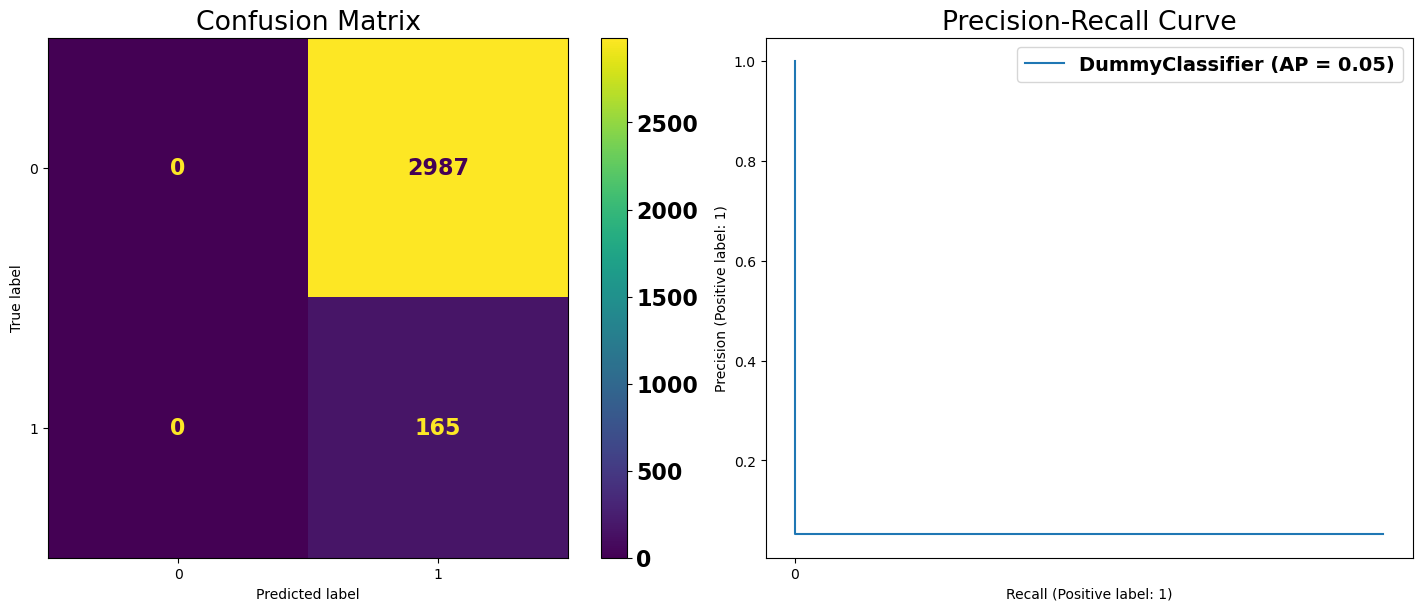

In [9]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)

# finding the best hyperparameter list for the model
result = run_model(dummy_clf, "Baseline Model", X_train, y_train, X_test, y_test)
result_list.append(result)

### Model 2: GradientBoostingClassifier (with OverSampling + UnderSampling)

best_params: 
    classifier__max_depth  :  2
    classifier__n_estimators  :  300

precision_recall_auc_score on training set: 0.281
precision_recall_auc_score on testing set: 0.255
perc_diff: 9.3 %

f1_score on training set: 0.342
f1_score on testing set: 0.277
perc_diff: 19.0 %

Confusion Matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2561              426
actual WnvPresent             70               95

 Plot Confusion Matrix and PR-AUC curve


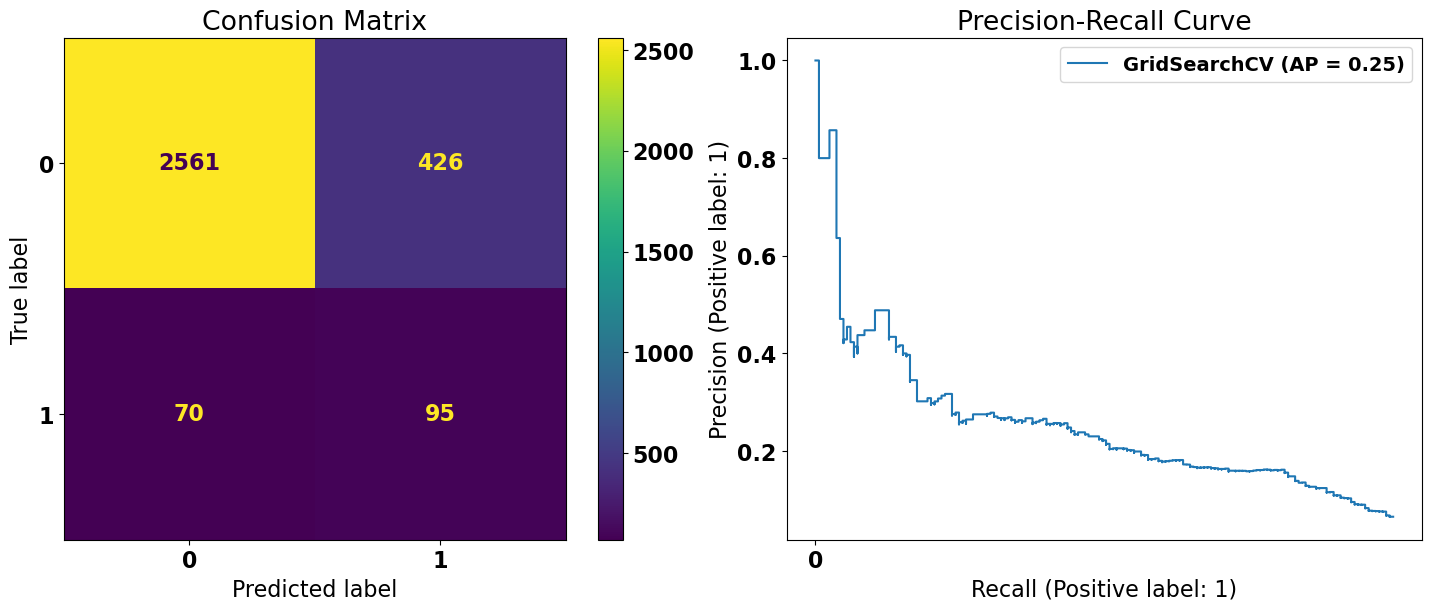

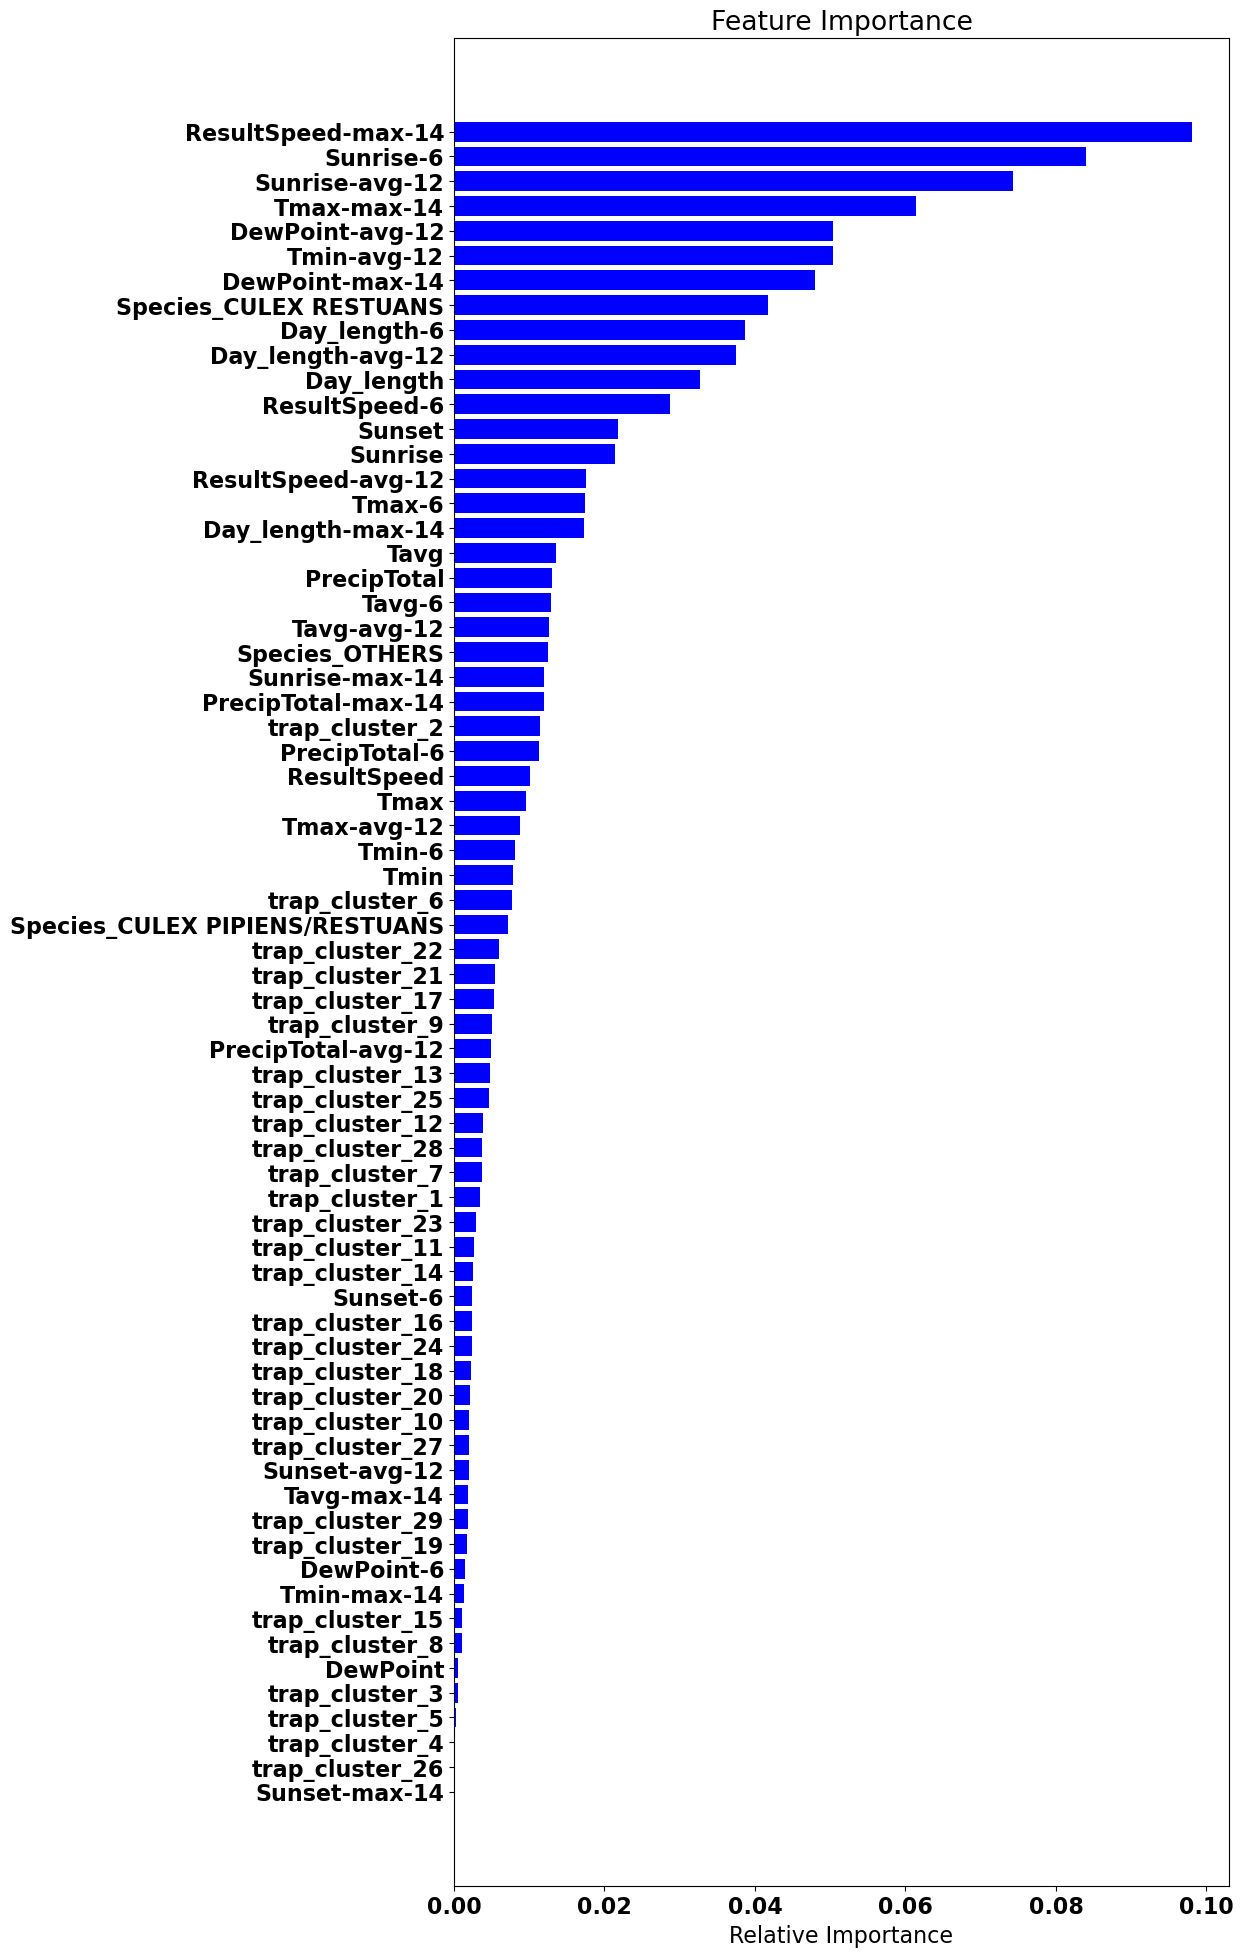

In [10]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = GradientBoostingClassifier(random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)

# pipeline parameters
pipe_params = {'classifier__n_estimators' : [300,500],       # The number of trees in the forest.
               'classifier__max_depth' : [2,3,4],              # The maximum depth of the tree.
               }

# Instantiate GridSearchCV.
# tscv = TimeSeriesSplit(n_splits=3)
gs_ougb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' # 'average_precision' = precision_recall_auc_score
                    )

# finding the best hypermeter list for the model
result = run_model(gs_ougb, "GradientBoost (Oversampling + Undersampling)", X_train, y_train, X_test, y_test)
result_list.append(result)

### Model 3: RandomForestClassifier (with OverSampling + UnderSampling)

best_params: 
    classifier__class_weight  :  {0: 1, 1: 5}
    classifier__max_depth  :  5
    classifier__n_estimators  :  300

precision_recall_auc_score on training set: 0.209
precision_recall_auc_score on testing set: 0.199
perc_diff: 4.6 %

f1_score on training set: 0.173
f1_score on testing set: 0.163
perc_diff: 5.6 %

Confusion Matrix: 
                   pred No virus  pred WnvPresent
actual No virus             1395             1592
actual WnvPresent              9              156

 Plot Confusion Matrix and PR-AUC curve


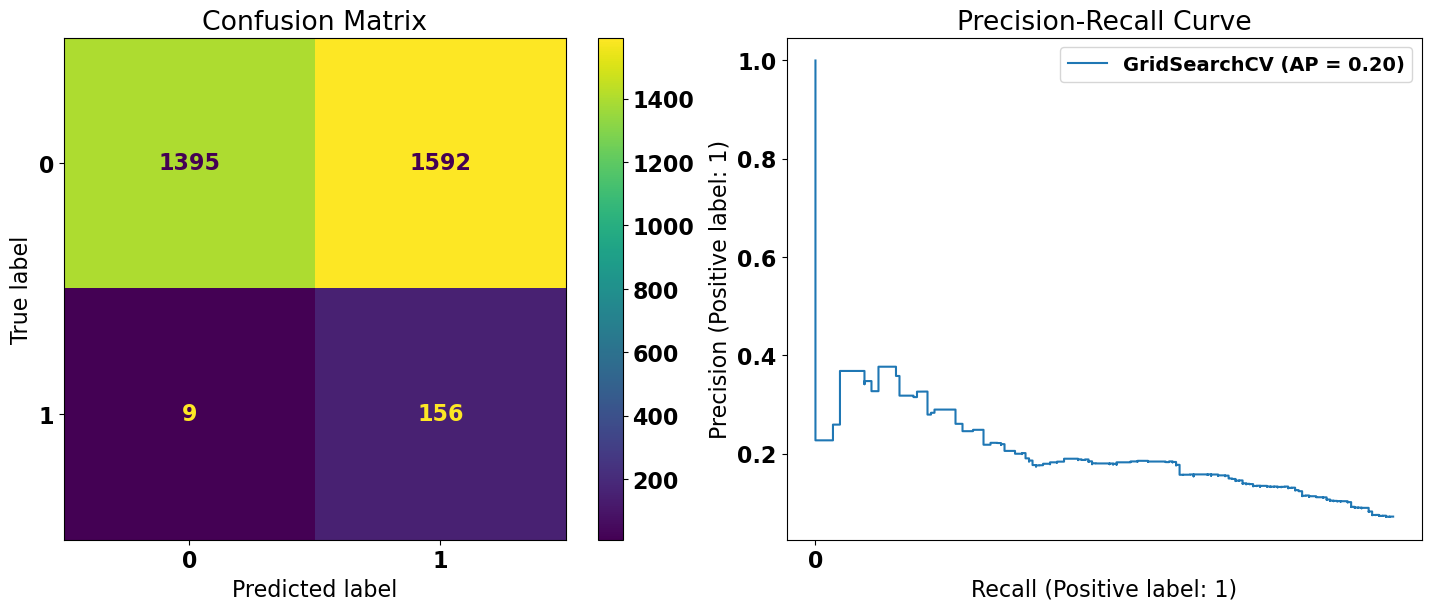

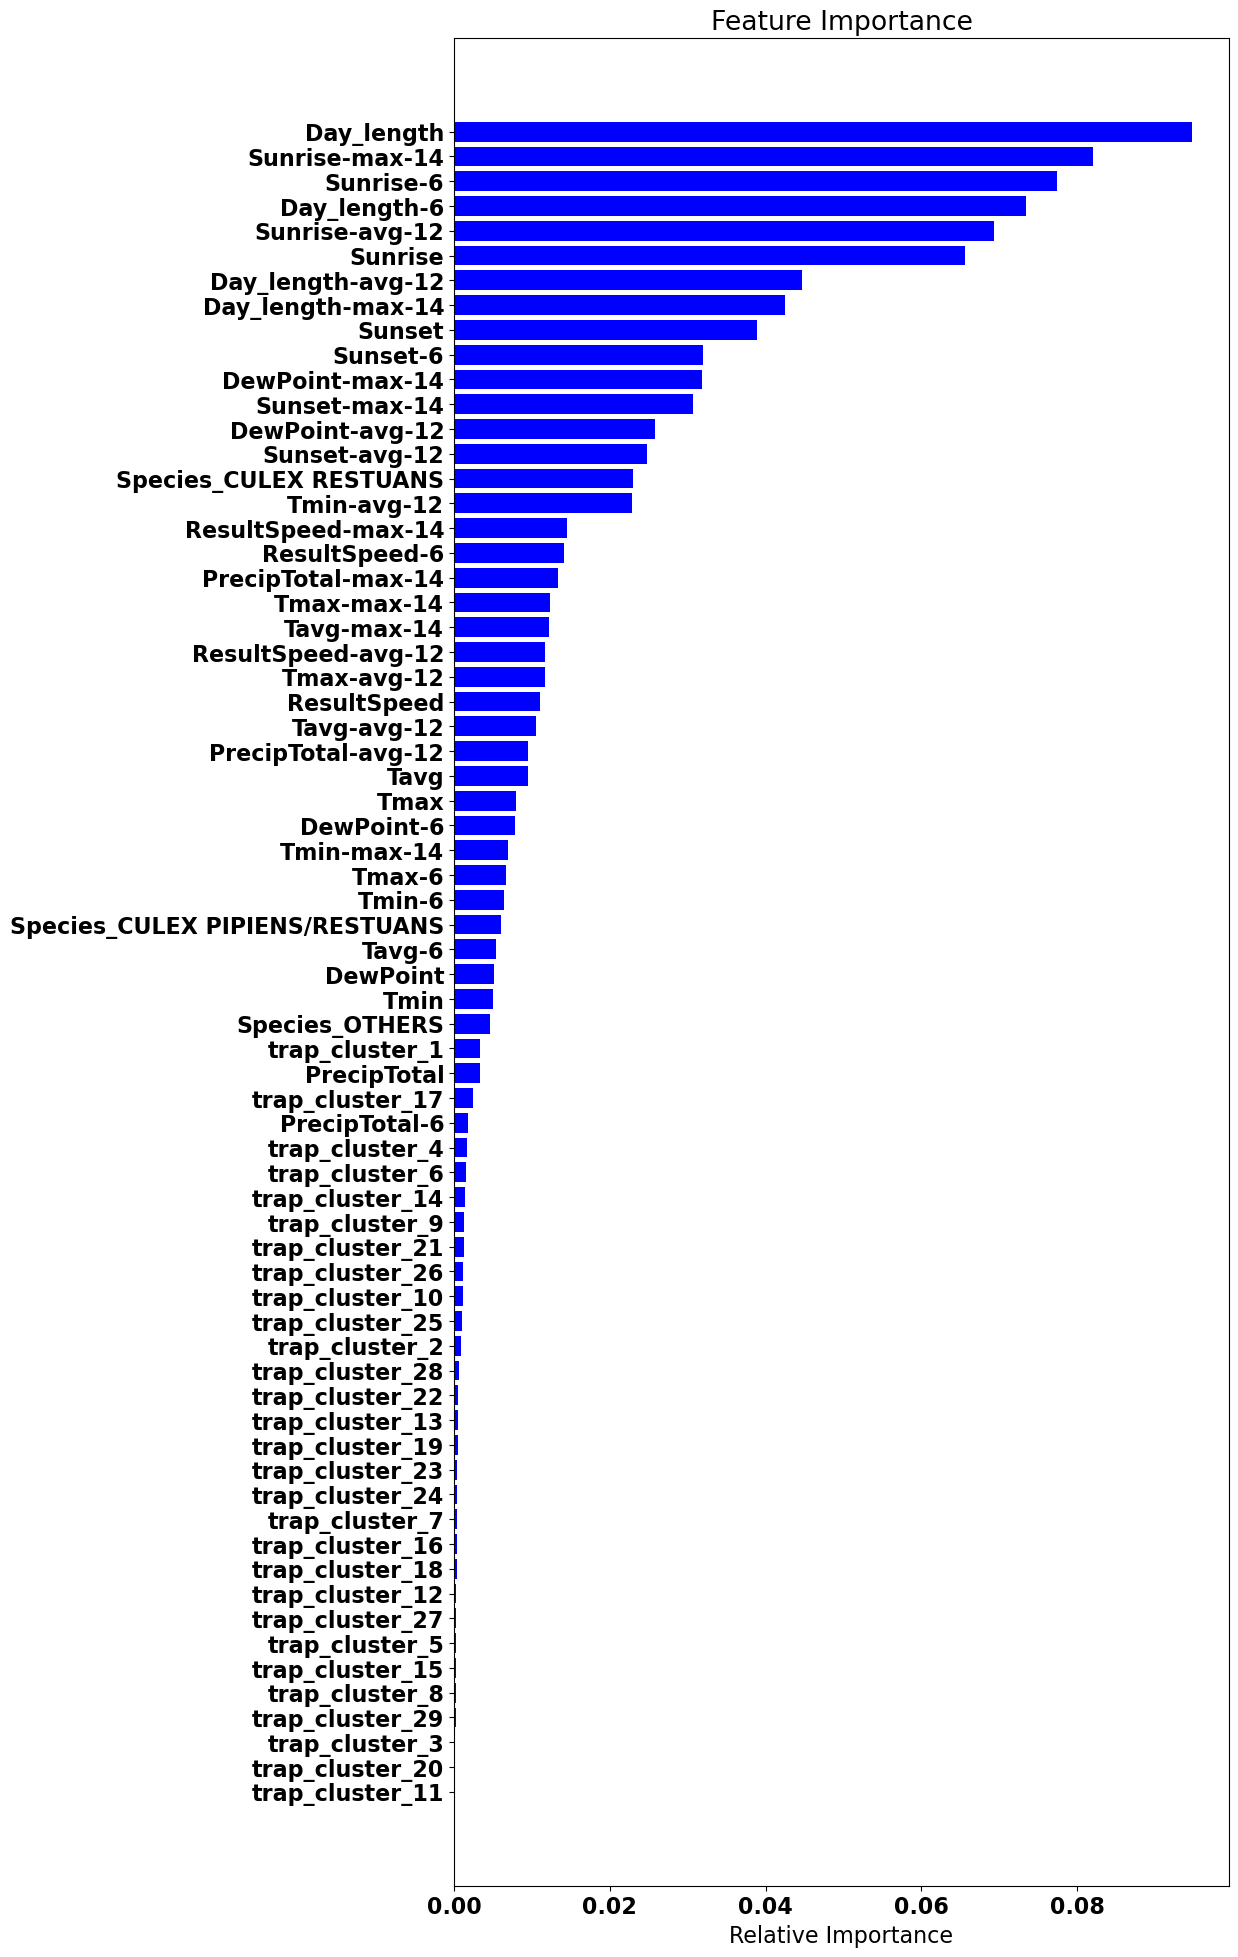

In [11]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = RandomForestClassifier(random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)

# pipeline parameters
pipe_params = {'classifier__n_estimators' : [300],       # The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              # The maximum depth of the tree.
                'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}] # adjust the weight of the imbalance
               }

# Instantiate GridSearchCV.
# tscv = TimeSeriesSplit(n_splits=3)
gs_ourf = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'  #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_ourf, "RandomForest (OverSampling + UnderSampling)", X_train, y_train, X_test, y_test )
result_list.append(result)

### Model 4:  LGBMClassifier (OverSampling + UnderSampling)

best_params: 
    classifier__learning_rate  :  0.05
    classifier__max_depth  :  5
    classifier__metric  :  auc
    classifier__num_leaves  :  30

precision_recall_auc_score on training set: 0.275
precision_recall_auc_score on testing set: 0.262
perc_diff: 4.7 %

f1_score on training set: 0.321
f1_score on testing set: 0.292
perc_diff: 9.2 %

Confusion Matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2549              438
actual WnvPresent             62              103

 Plot Confusion Matrix and PR-AUC curve


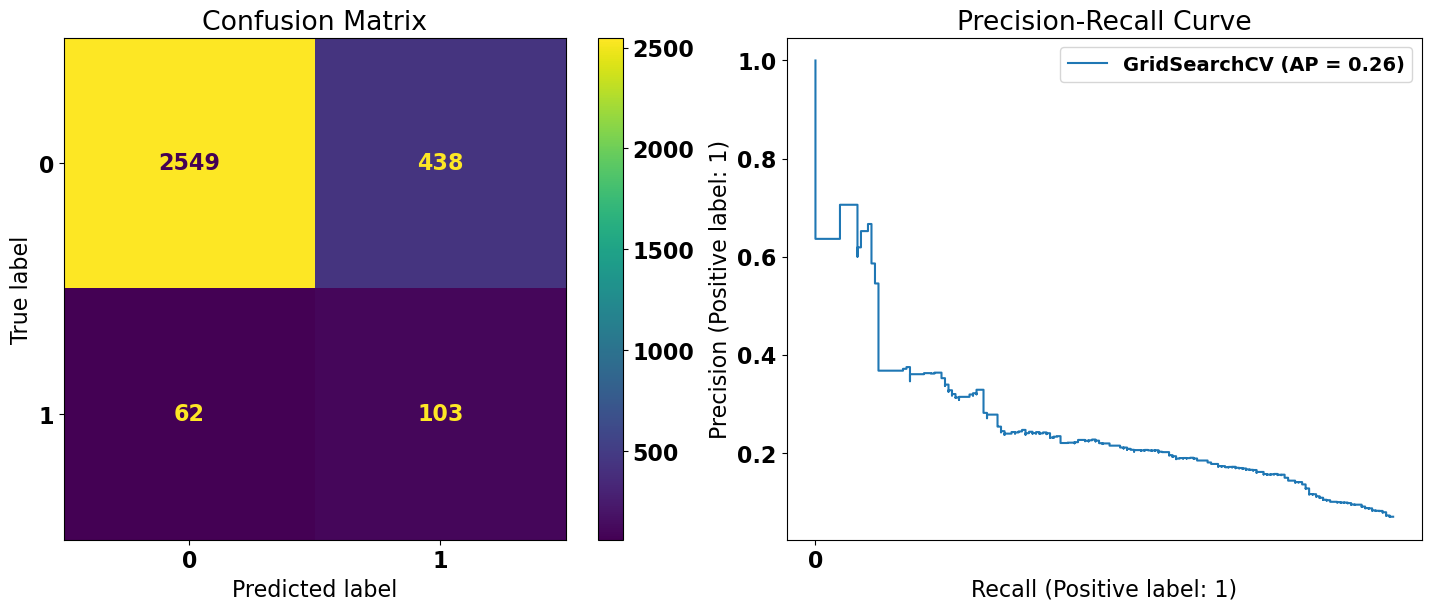

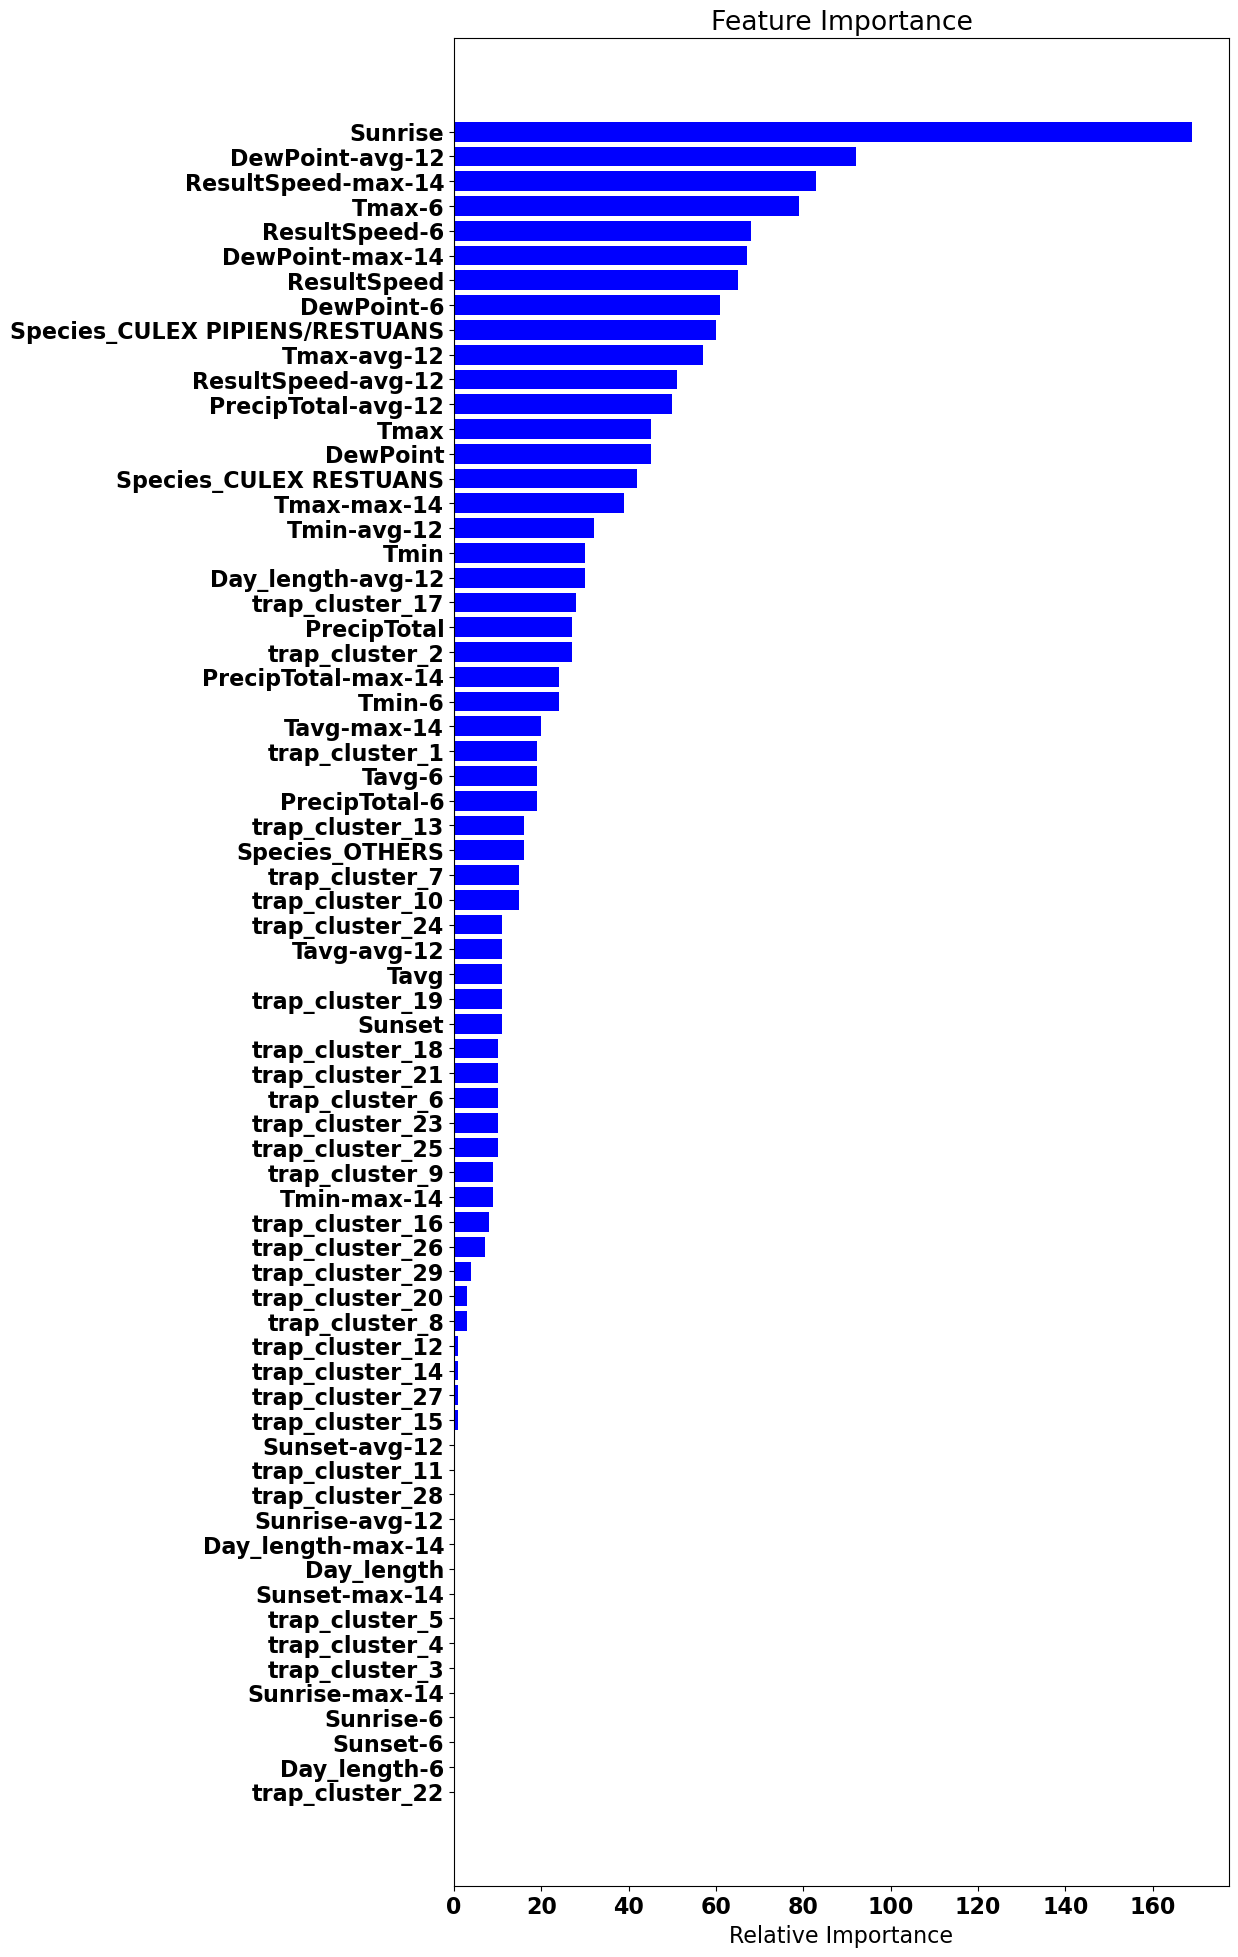

In [12]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = lgb.LGBMClassifier(objective='binary', random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)

# pipeline parameters
pipe_params = { 'classifier__num_leaves' : [30,35,40],   #The number of trees in the forest.
                'classifier__learning_rate' : [.01,0.05],   #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                #'classifier__is_unbalance': ['True'],
                'classifier__metric' : ['auc', 'binary_logloss', 'average_precision']  # Use different metrics
                }

# Instantiate GridSearchCV.
# tscv = TimeSeriesSplit(n_splits=3)
gs_oulgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=5, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_oulgb, "LightGBM (OverSampling + UnderSampling)",  X_train, y_train, X_test, y_test )
result_list.append(result)

### Model 5: SMOTE + GradientBoostingClassifier

best_params: 
    classifier__max_depth  :  2
    classifier__n_estimators  :  300

precision_recall_auc_score on training set: 0.271
precision_recall_auc_score on testing set: 0.261
perc_diff: 3.4 %

f1_score on training set: 0.328
f1_score on testing set: 0.311
perc_diff: 5.1 %

Confusion Matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2870              117
actual WnvPresent            113               52

 Plot Confusion Matrix and PR-AUC curve


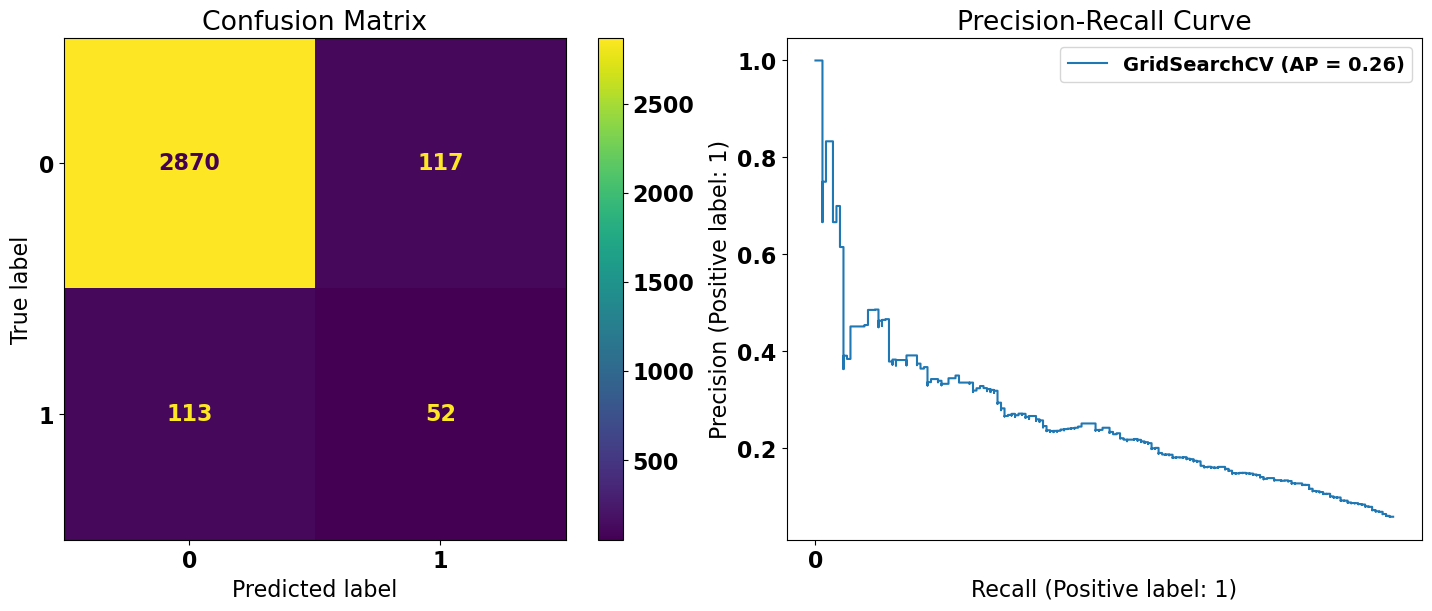

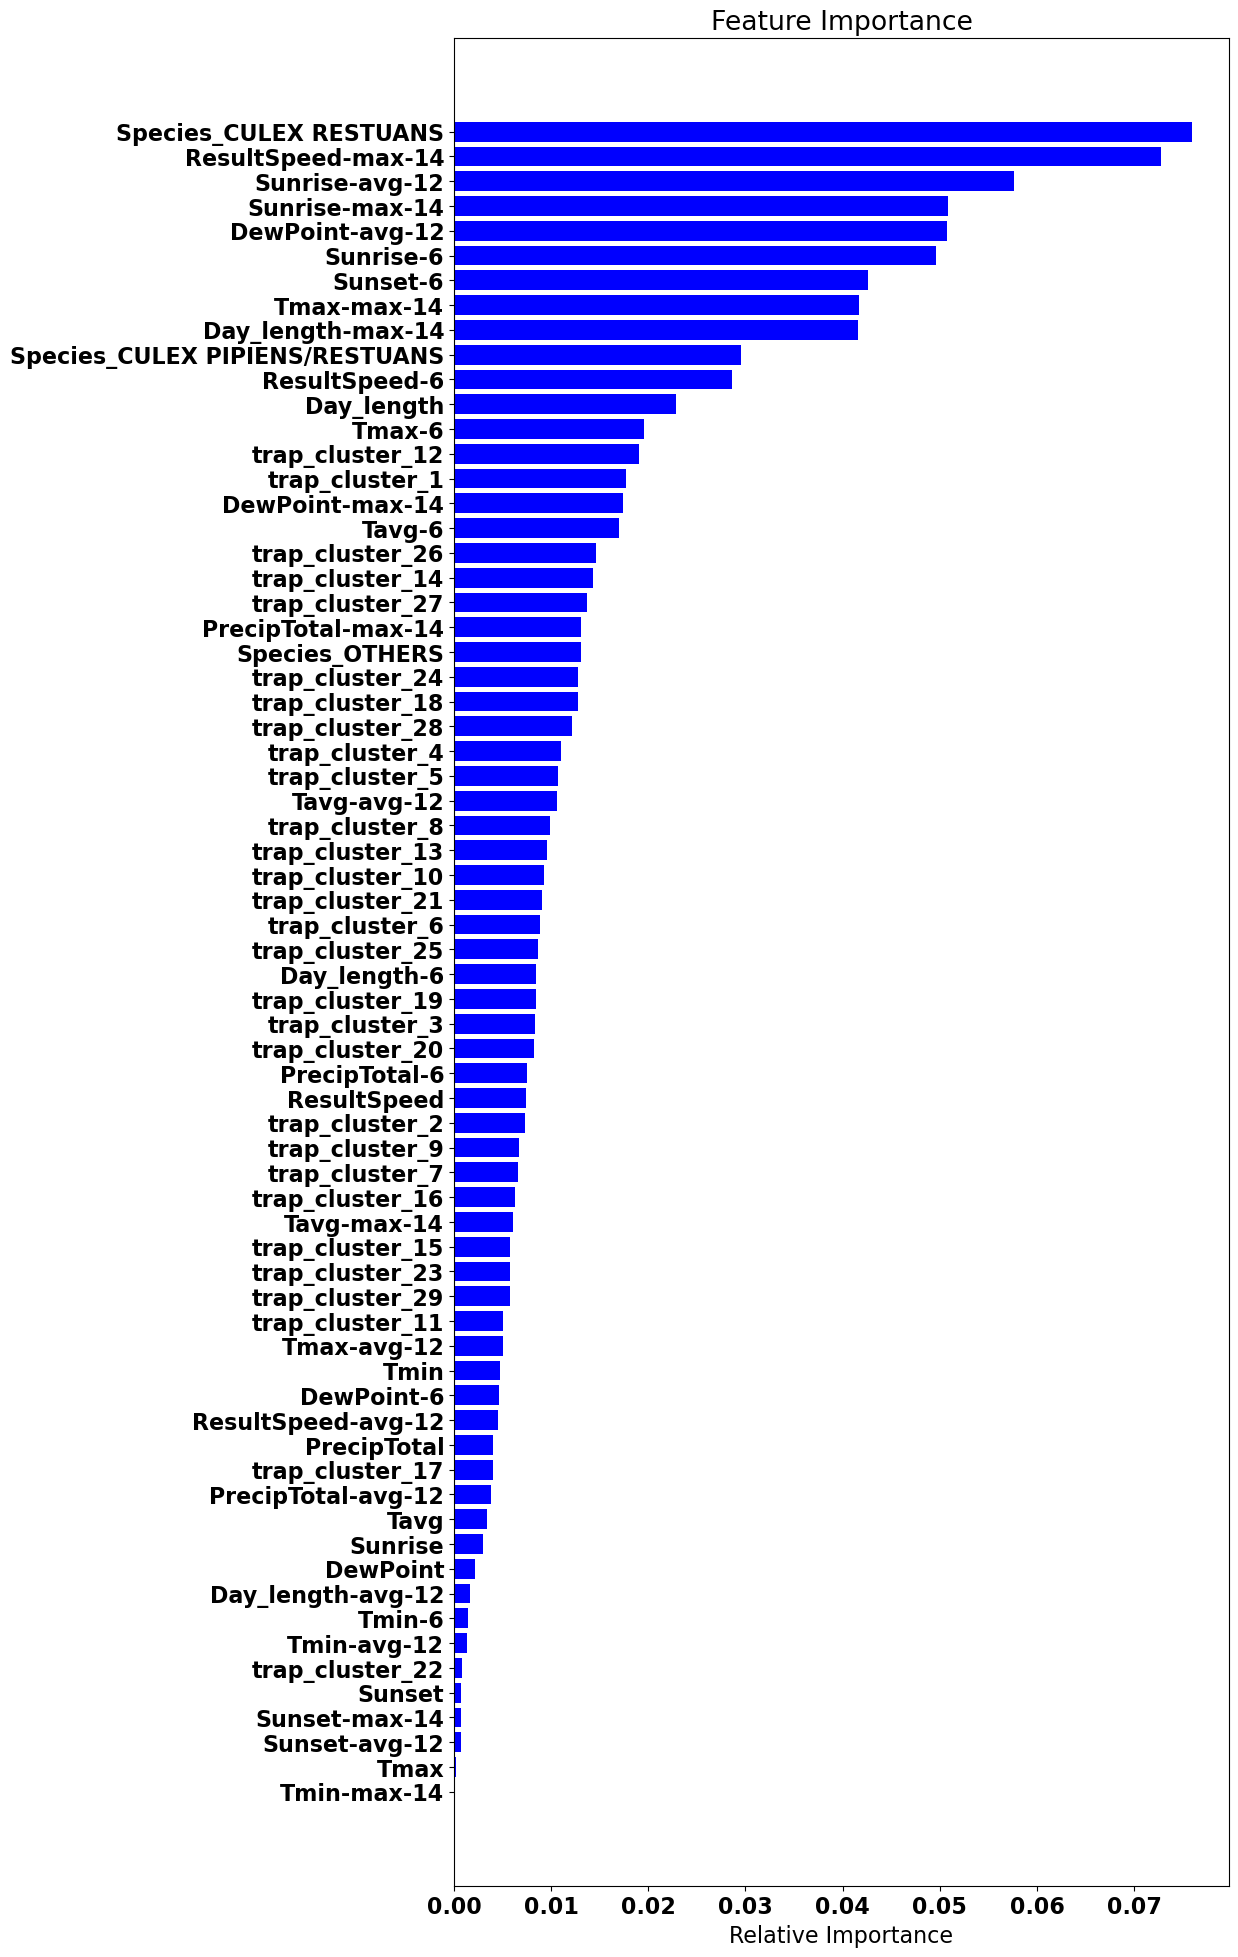

In [13]:
# define pipeline
# over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
# under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
sm = SMOTE(sampling_strategy=0.33, random_state=random_key)
model = GradientBoostingClassifier(random_state=random_key)

#steps = [('o', over), ('u', under), ('classifier', model)]
steps = [('smote', sm),  ('classifier', model)]
pipe = Pipeline(steps=steps)

#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300,500],       #The number of trees in the forest.
               'classifier__max_depth' : [2,3,4],              #The maximum depth of the tree.
               }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_smgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_smgb, "SMOTE + GradientBoost", X_train, y_train, X_test, y_test)
result_list.append(result)

### Model 6: SMOTE + RandomForestClassifier

best_params: 
    classifier__class_weight  :  {0: 1, 1: 10}
    classifier__max_depth  :  6
    classifier__n_estimators  :  300

precision_recall_auc_score on training set: 0.214
precision_recall_auc_score on testing set: 0.193
perc_diff: 9.8 %

f1_score on training set: 0.180
f1_score on testing set: 0.174
perc_diff: 3.1 %

Confusion Matrix: 
                   pred No virus  pred WnvPresent
actual No virus             1518             1469
actual WnvPresent              9              156

 Plot Confusion Matrix and PR-AUC curve


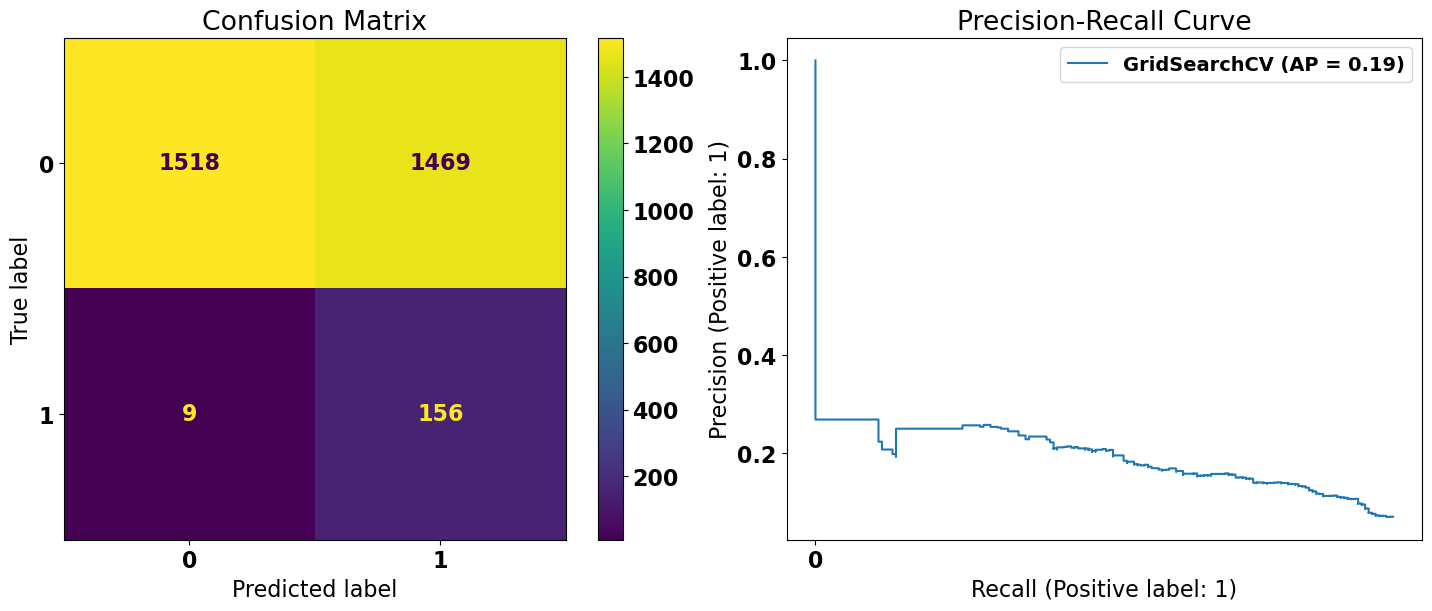

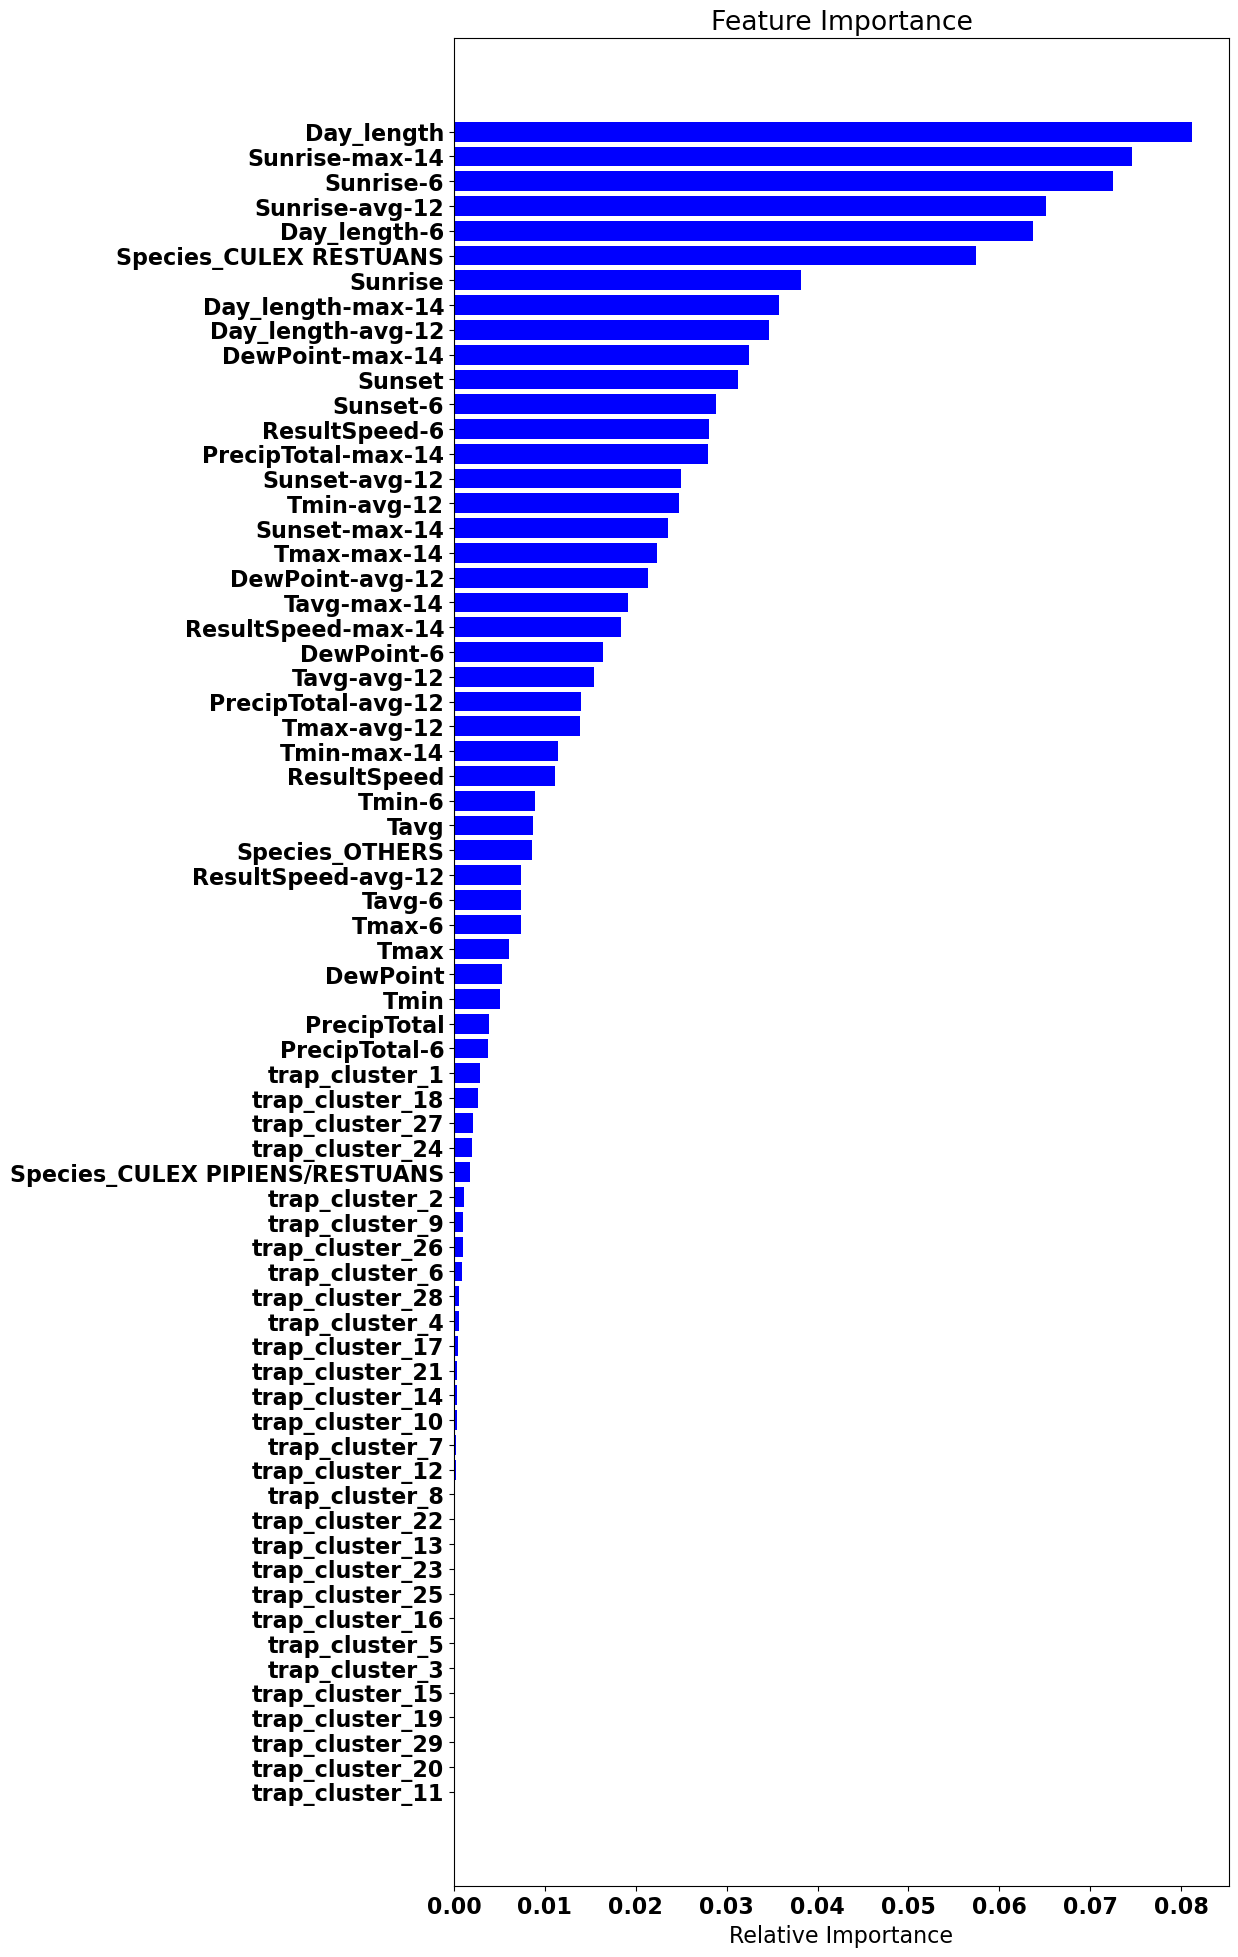

In [14]:
# define pipeline
#over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
#under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
sm = SMOTE(sampling_strategy=0.33, random_state=random_key)
model = RandomForestClassifier(random_state=random_key)

#steps = [('o', over), ('u', under), ('classifier', model)]
steps = [('smote', sm),  ('classifier', model)]
pipe = Pipeline(steps=steps)

# pipeline parameters
pipe_params = {'classifier__n_estimators' : [300],       #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
               }

# Instantiate GridSearchCV.
# tscv = TimeSeriesSplit(n_splits=3)
gs_smrf = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'  #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_smrf, "SMOTE + RandomForest", X_train, y_train, X_test, y_test )
result_list.append(result)

### Model 7: SMOTE + LGBMClassifier

best_params: 
    classifier__learning_rate  :  0.05
    classifier__max_depth  :  6
    classifier__metric  :  auc
    classifier__num_leaves  :  40

precision_recall_auc_score on training set: 0.294
precision_recall_auc_score on testing set: 0.295
perc_diff: 0.3 %

f1_score on training set: 0.400
f1_score on testing set: 0.333
perc_diff: 16.7 %

Confusion Matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2802              185
actual WnvPresent             95               70

 Plot Confusion Matrix and PR-AUC curve


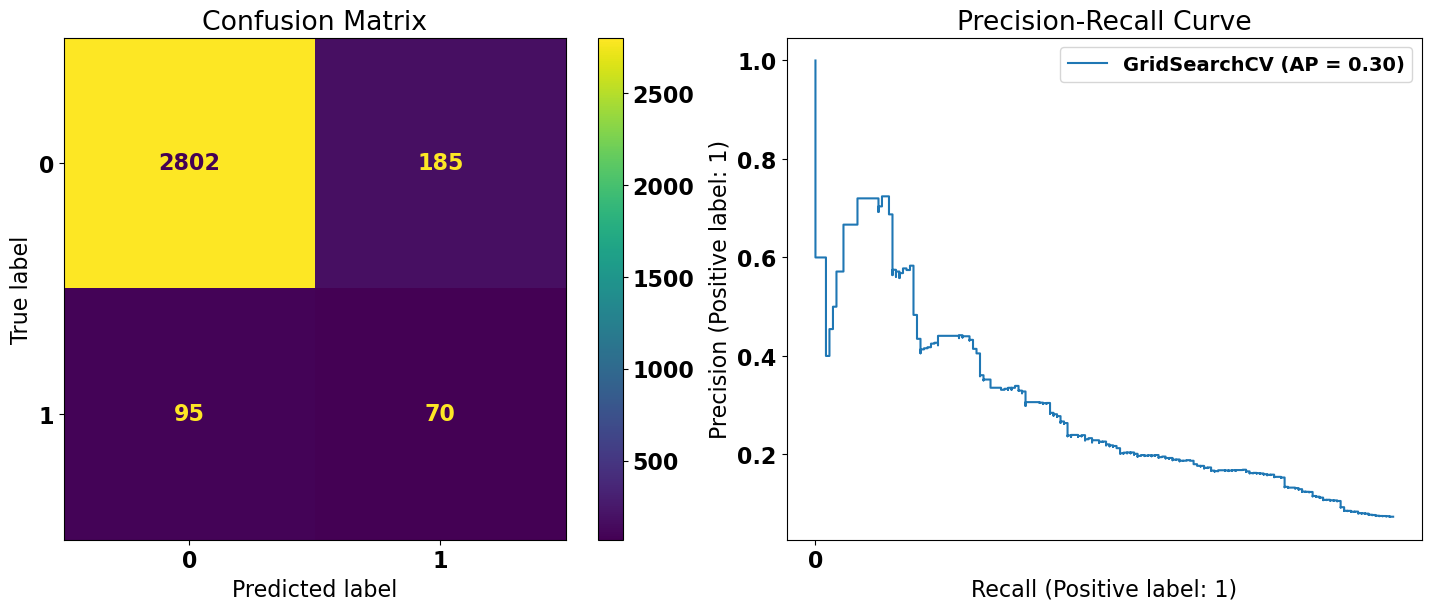

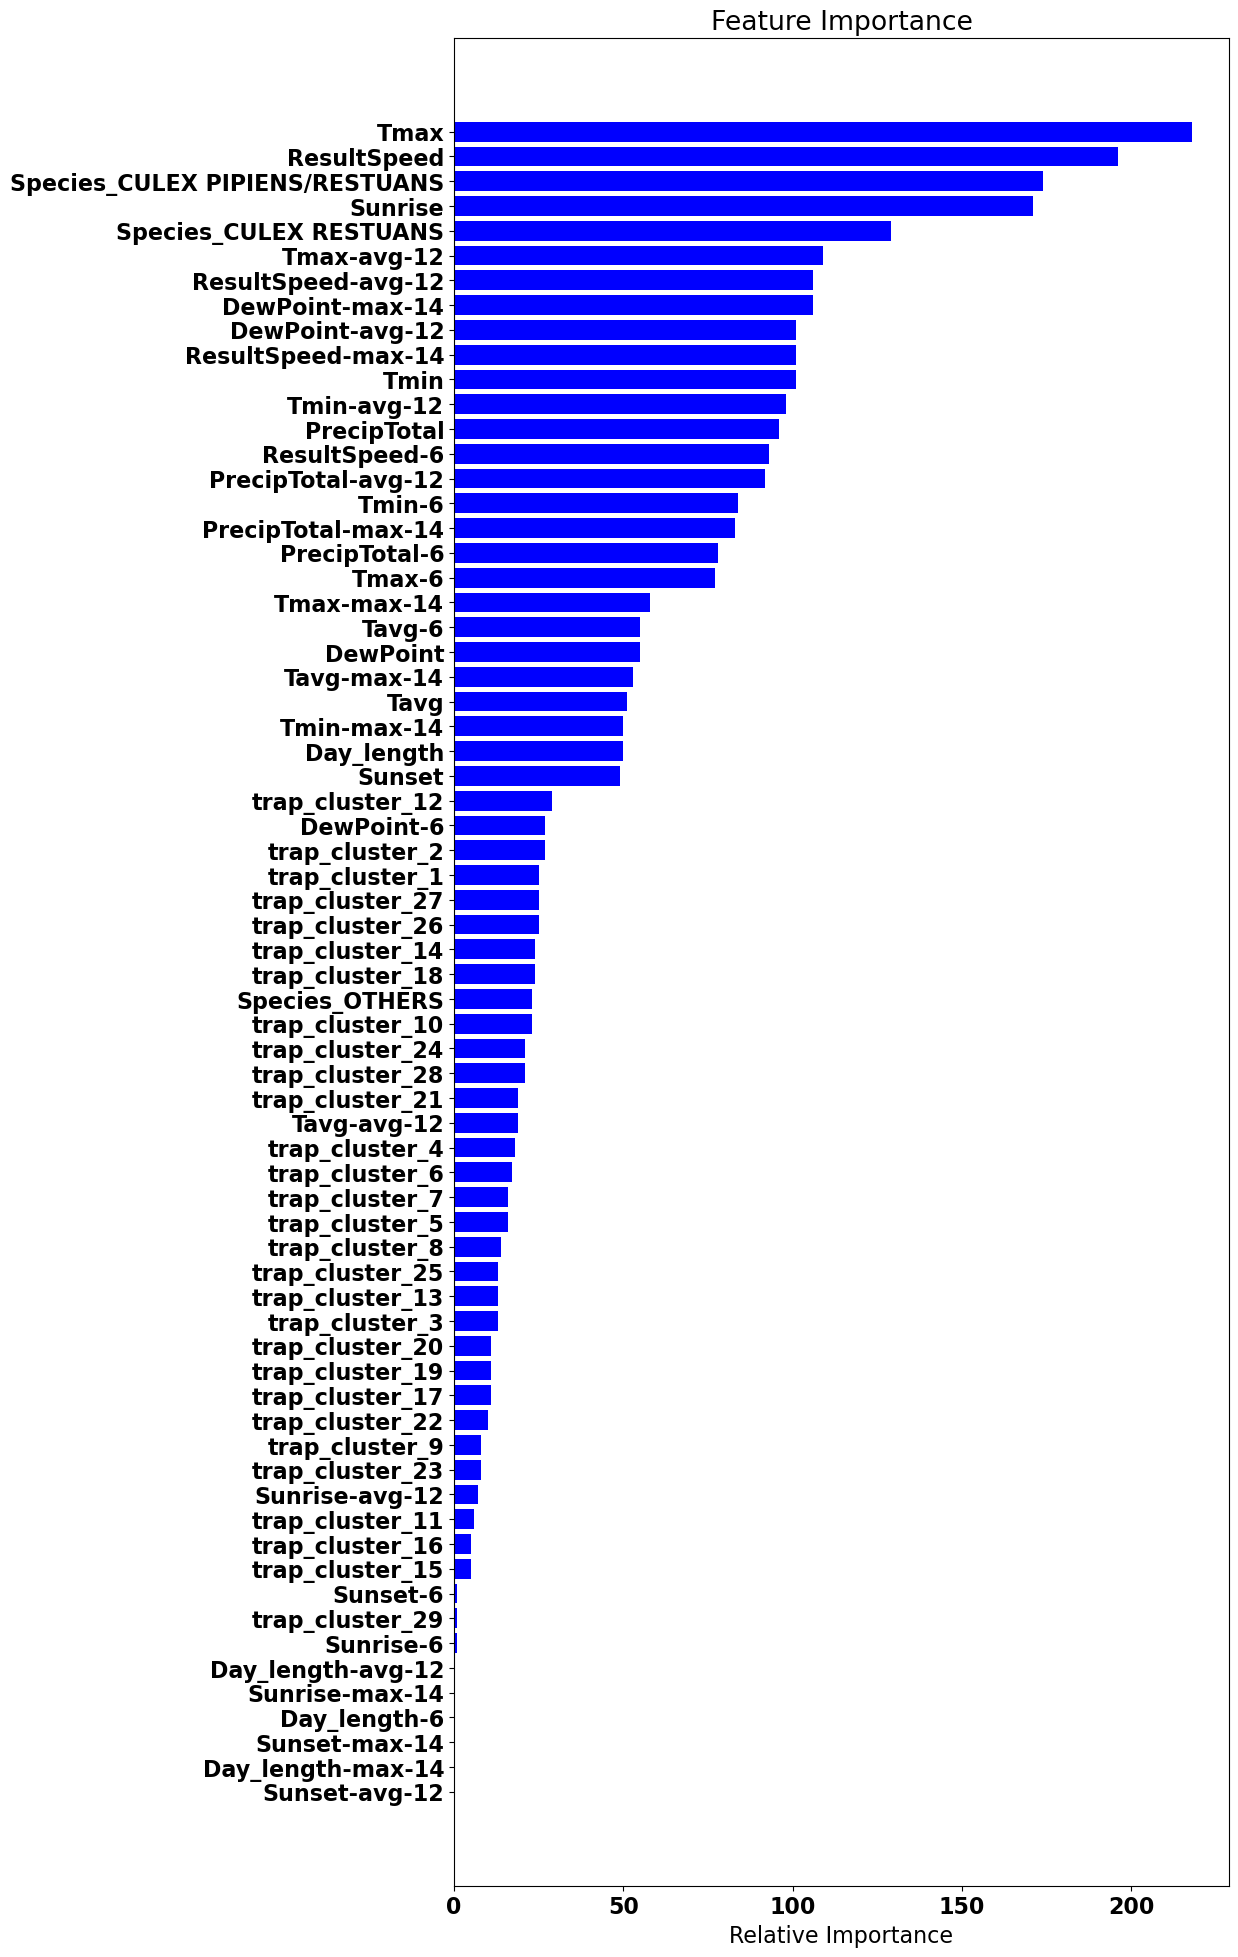

In [15]:
# define pipeline
# over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
# under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
sm = SMOTE(sampling_strategy=0.33, random_state=random_key)
model = lgb.LGBMClassifier(objective='binary', random_state=random_key)

#steps = [('o', over), ('u', under), ('classifier', model)]
steps = [('smote', sm),  ('classifier', model)]
pipe = Pipeline(steps=steps)


# pipeline parameters
pipe_params = { 'classifier__num_leaves' : [30,35,40],   # The number of trees in the forest.
                'classifier__learning_rate' : [.01,0.05],   # The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              # The maximum depth of the tree.
               # 'classifier__is_unbalance': ['True','False'],
                'classifier__metric' : ['auc', 'binary_logloss','average_precision'] # Different metrics
                }

# Instantiate GridSearchCV.
# tscv = TimeSeriesSplit(n_splits=3)
gs_smlgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=5, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_smlgb, "SMOTE + LightGBM",  X_train, y_train, X_test, y_test )
result_list.append(result)

# Model Evaluation
- Precision-Recall Curve Comparison
- ROC-AUC Curve Comparison
- Observations

*Back to [Contents](#Contents:)*

In [16]:
# Table of evalution metrics from all the models
result_final = pd.concat(result_list, axis=0)
result_final

,Precision Recall AUC Train,Precision Recall AUC Test,Precision Recall AUC Generalization %,F1 Score Train,F1 Score Test,F1 Score Generalization %
Baseline Model,0.05,0.05,0.27,0.10,0.10,0.25
GradientBoost (Oversampling + Undersampling),0.28,0.25,9.33,0.34,0.28,18.95
RandomForest (OverSampling + UnderSampling),0.21,0.20,4.59,0.17,0.16,5.62
LightGBM (OverSampling + UnderSampling),0.28,0.26,4.67,0.32,0.29,9.15
SMOTE + GradientBoost,0.27,0.26,3.43,0.33,0.31,5.07
SMOTE + RandomForest,0.21,0.19,9.84,0.18,0.17,3.09
SMOTE + LightGBM,0.29,0.30,0.26,0.40,0.33,16.67


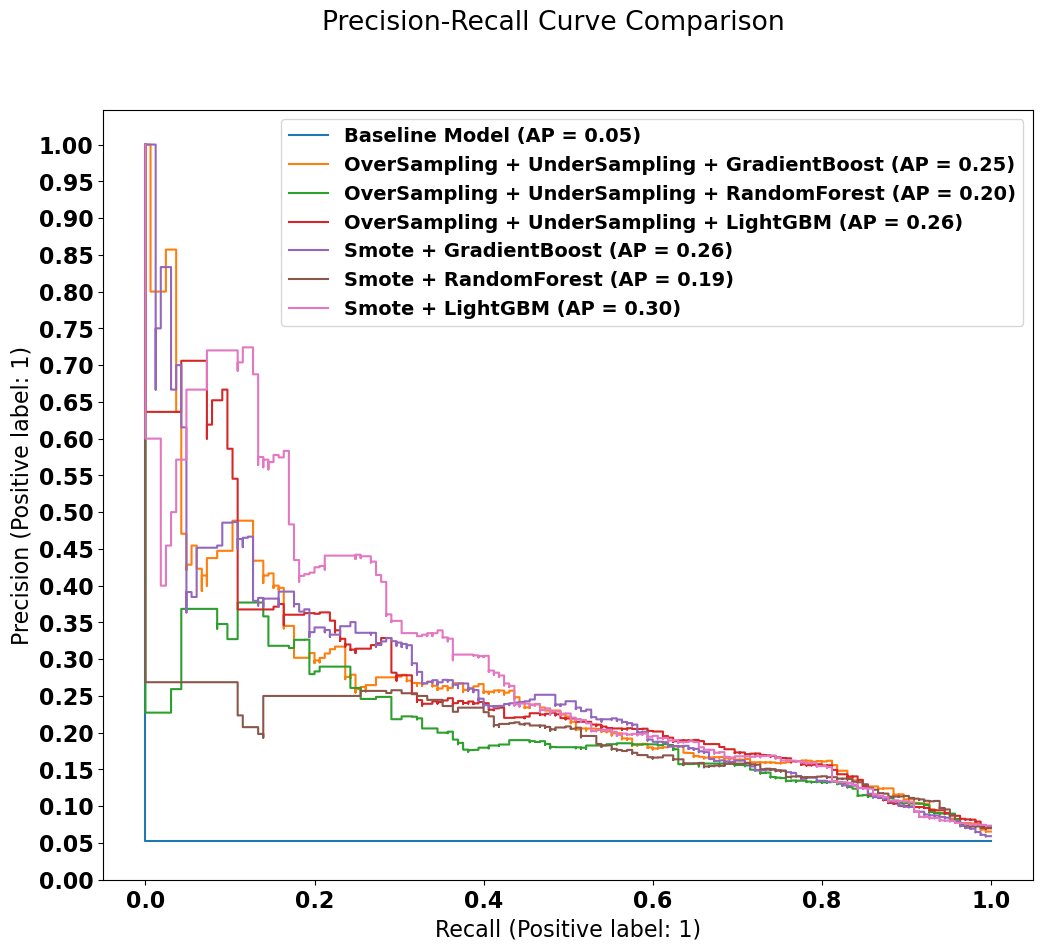

In [17]:
# Comparing Precision-Recall Curve
plt.rcParams['figure.figsize'] = (12.0, 10.0)

# AP score after each model summarizes Precision-Recall curve 
# as the weighted mean of precision acheived at each threshold
fig = PrecisionRecallDisplay.from_estimator(dummy_clf, X_test, y_test, name="Baseline Model")

PrecisionRecallDisplay.from_estimator(gs_ougb, X_test, y_test, name="OverSampling + UnderSampling + GradientBoost",ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_ourf, X_test, y_test, name='OverSampling + UnderSampling + RandomForest',ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_oulgb, X_test, y_test, name='OverSampling + UnderSampling + LightGBM',ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_smgb, X_test, y_test, name="Smote + GradientBoost",ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_smrf, X_test, y_test, name='Smote + RandomForest',ax = fig.ax_)
PrecisionRecallDisplay.from_estimator(gs_smlgb, X_test, y_test, name='Smote + LightGBM',ax = fig.ax_)

fig.ax_.legend(loc='upper right', fontsize=14)
fig.ax_.set_yticks(np.arange(0, 1.05, 0.05))
fig.figure_.suptitle("Precision-Recall Curve Comparison")
plt.show()

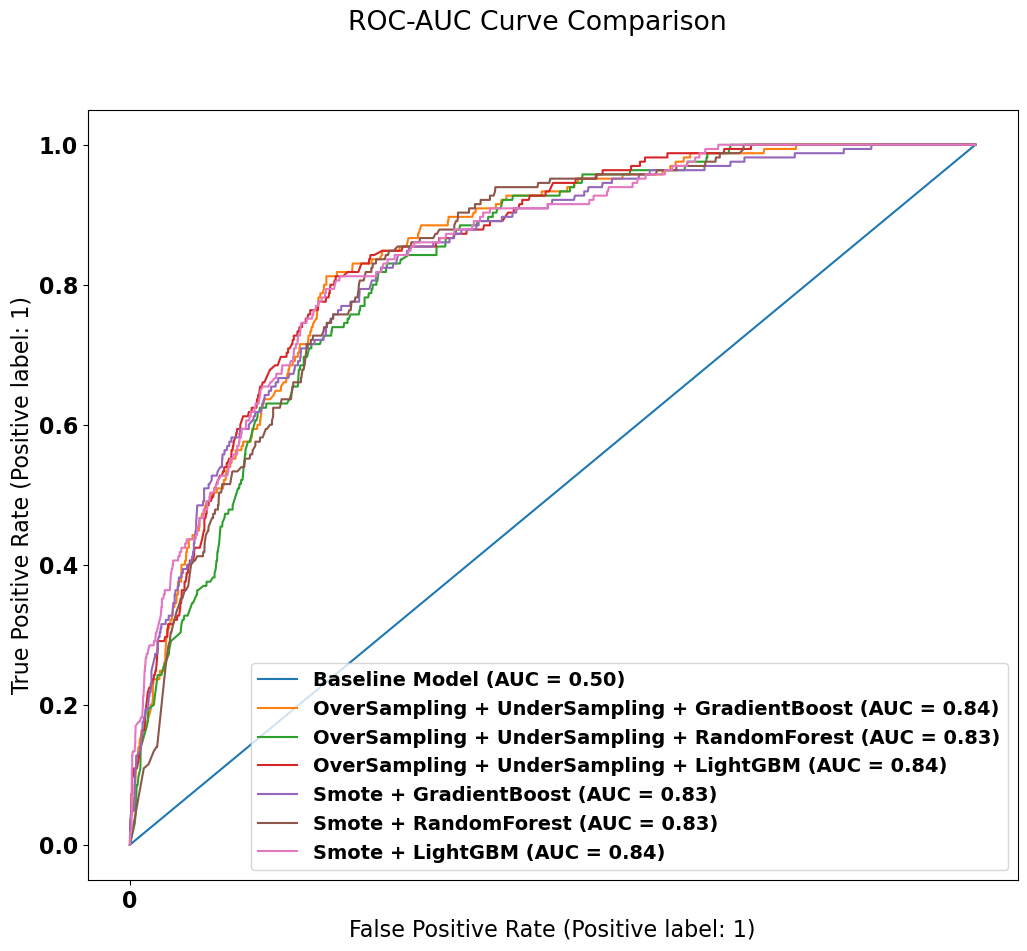

In [18]:
# Comparing ROC AUC Curve
plt.rcParams['figure.figsize'] = (12.0, 10.0)

# Plot ROC curve
fig=RocCurveDisplay.from_estimator(dummy_clf, X_test, y_test,name="Baseline Model") 

RocCurveDisplay.from_estimator(gs_ougb, X_test, y_test,name="OverSampling + UnderSampling + GradientBoost",ax = fig.ax_)
RocCurveDisplay.from_estimator(gs_ourf, X_test, y_test, name='OverSampling + UnderSampling + RandomForest',ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_oulgb, X_test, y_test, name='OverSampling + UnderSampling + LightGBM',ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_smgb, X_test, y_test,name="Smote + GradientBoost",ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_smrf, X_test, y_test, name='Smote + RandomForest',ax = fig.ax_)
RocCurveDisplay.from_estimator(gs_smlgb, X_test, y_test, name='Smote + LightGBM',ax = fig.ax_) 

fig.ax_.legend(loc='lower right', fontsize=14)
fig.figure_.suptitle("ROC-AUC Curve Comparison")
fig.ax_.set_xticks(np.arange(0, 1, 20))
plt.show()

### Observations
- From the table, all models do not perform well as seem from their low AUC-PR and F1 scores
- `Model 7: SMOTE + LGBMClassifier` will be chosen as the production model at this stage as it has the best score and generalization
- Feature Importance: Mosquito species and weather conditions are the most important features, while some trap locations also provide mild contributions.

### Future Improvements
- To include more weather features from the weather data sets
- To try more different lagged days
- To try more different algorithms such as CatBoost, XGBoost
- To try ensemble algorithms

# Model Submission
*Back to [Contents](#Contents:)*

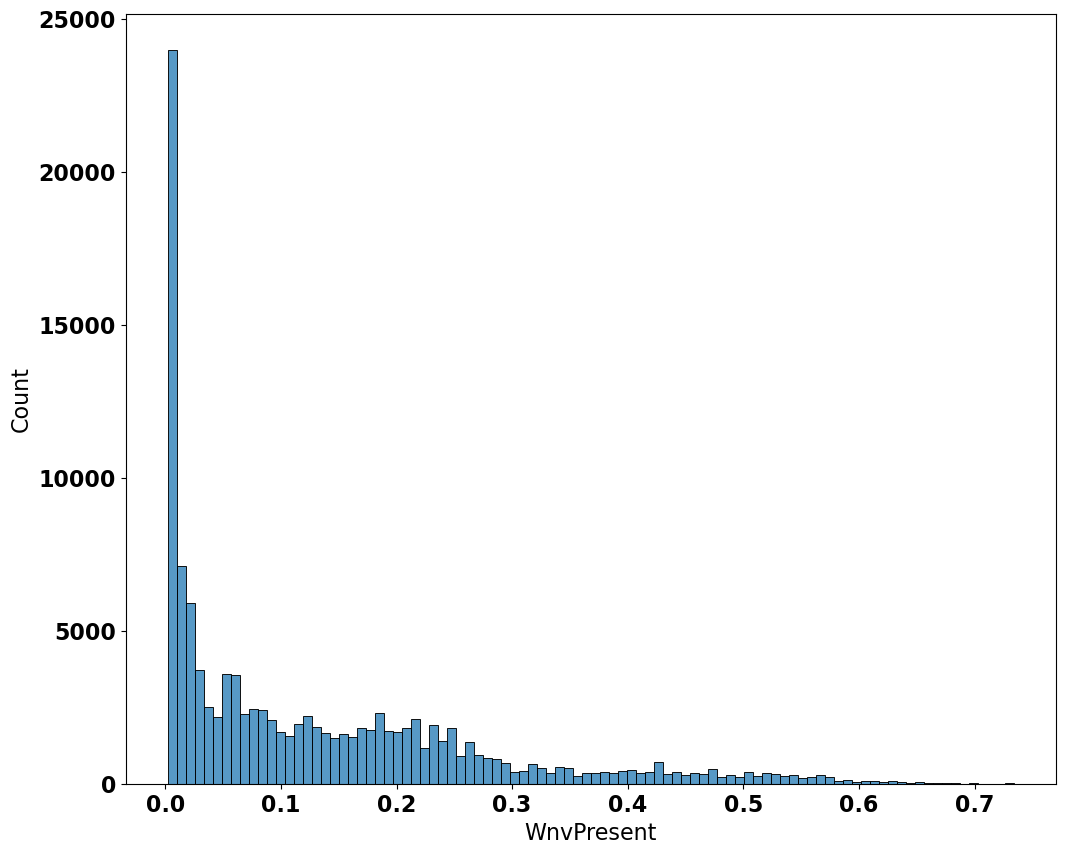

In [19]:
# Generate a list of the probability of predicting WNV using the Test set
WnvPresent_prob_list = gs_oulgb.predict_proba(X_submission)

# We only want to take the probability of the Positive Class i.e. Prob of WNV being present
df_test['WnvPresent'] = [list(t) for t in zip(*WnvPresent_prob_list)][1]

# Df of IDs and probability of WNV
df_submission = df_test[['Id','WnvPresent']]

df_submission.to_csv("../assets/submission.csv", index=False)
sns.histplot(df_submission['WnvPresent']);